In [1]:
#Import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

import matplotlib.font_manager as font_manager
font_manager._get_fontconfig_fonts.cache_clear() # this is just to refresh the cache for fonts, maybe it's not even needed

# Read data using pandas

In [2]:
df = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Z_boson.csv') # read csv file, df stands for dataframe
df['class'] = df['class'].map({'Zee': 0, 'Zmumu': 1}) # convert into numeric
# la [] è il modo per accedere alla colonna, se ne vuoi prendere di + tra le [] ci devi passare un array con i nomi dle colonne
# se vuoi filtrare gli elem puoi metterci dle condizioni logiche stile if
# per accedere a degli elementi df.iloc[riga,colonna] (parte da 0), e ci puoi usare tutti i metodi che conosci per gli indici (es :)
# se pensi a tutto il df come ad un 2d array occhio solo che l'indice dla 1a riga (e nn qla con i nomi dle colonne) è 0
df = df.drop(['Unnamed: 0'], axis=1) # remove unwanted column (because we set axis=1) 
df.head() # mostra le 1e () righe dl dataframe, se vuoi il fondo usa .tail()

,Run,Event,pt1,eta1,phi1,Q1,pt2,eta2,phi2,Q2,class
0,166784,20257329,42.9130,-1.3248,-3.0057,-1,42.2897,-0.6624,0.3485,1,1
1,163261,64679856,39.8744,-0.0057,-0.7744,-1,36.3997,1.3710,2.2952,1,0
2,165570,196860468,72.9296,-0.4162,0.9198,1,39.5410,-0.2680,-1.4629,1,0
3,172163,497791581,33.4436,0.3063,-1.6034,1,27.2395,-1.6182,1.5315,-1,0
4,173692,550966077,43.9826,0.4276,-0.3876,-1,29.7856,-0.3080,2.8965,1,1


**There are 20,000 rows in the dataset with 10 features and a target output (class), and there are no NaN values.**

In [6]:
df.info() # o altrim .columns() o solo i tipi con .types()
# interessante che mi dica i nn null count
# se vuoi un conditional based update degli elementi di 1 col usa .apply(function) sla col

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     20000 non-null  int64  
 1   Event   20000 non-null  int64  
 2   pt1     20000 non-null  float64
 3   eta1    20000 non-null  float64
 4   phi1    20000 non-null  float64
 5   Q1      20000 non-null  int64  
 6   pt2     20000 non-null  float64
 7   eta2    20000 non-null  float64
 8   phi2    20000 non-null  float64
 9   Q2      20000 non-null  int64  
 10  class   20000 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.7 MB


**Target (class): there are 10,000 Zee (or 0) and Zmumu (or 1) events in the chart below. In this case, the dataset is balanced with two possible outcomes.**

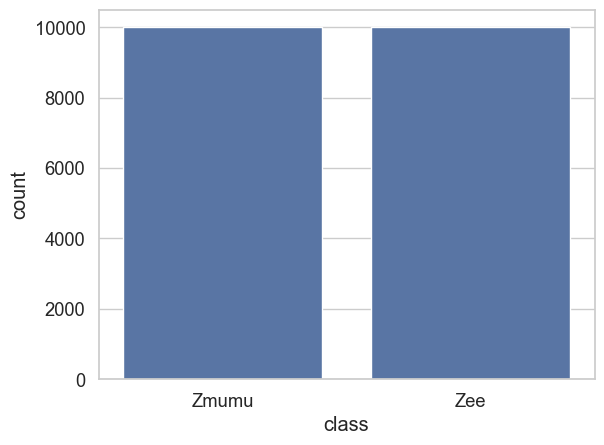

In [7]:
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
df1 = df.copy()
df1['class'] = df1['class'].map({0: 'Zee', 1: 'Zmumu'})
sns.countplot(data=df1, x="class")
del df1

# Boxplot and Outliers

`Event`, `pt1`, and `pt2` are three features exhibiting outliers.

<Axes: >

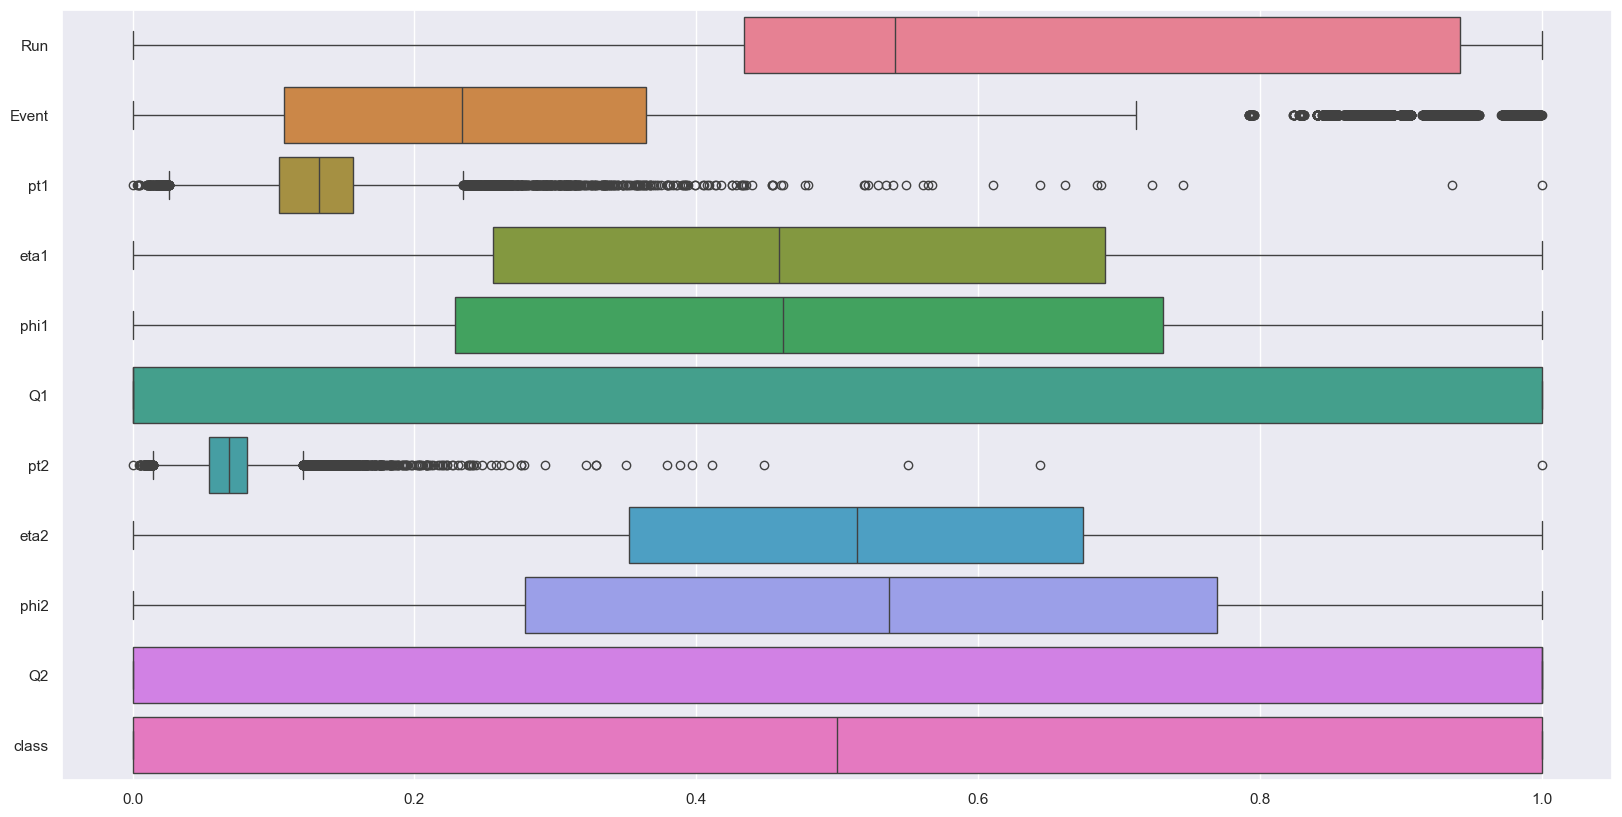

In [8]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df) # normalization
df_array_to_df = pd.DataFrame(df_scaled, columns = df.columns) # convert array into dataframe
plt.figure(figsize=(20, 10)) 
sns.set(font_scale=1.0)
sns.boxplot(data=df_array_to_df, orient="h")

The skewness is a measure of symmetry or asymmetry of data distribution. Data can be positive-skewed (data-pushed towards the right side) or negative-skewed (data-pushed towards the left side). For pt1, the skewness is between -0.5 & 0.5, so the data are nearly symmetrical. But, for pt2, the skewness is greater than 1 (positive skewed), so the data are extremely skewed. When data is skewed, the tail region may behave as an outlier for the statistical model, and outliers unsympathetically affect the model’s performance. Some statistical models are hard to outliers like Tree-based models, but it will limit the possibility of trying other models. So there is a necessity to transform the skewed data to be close enough to a Normal distribution.

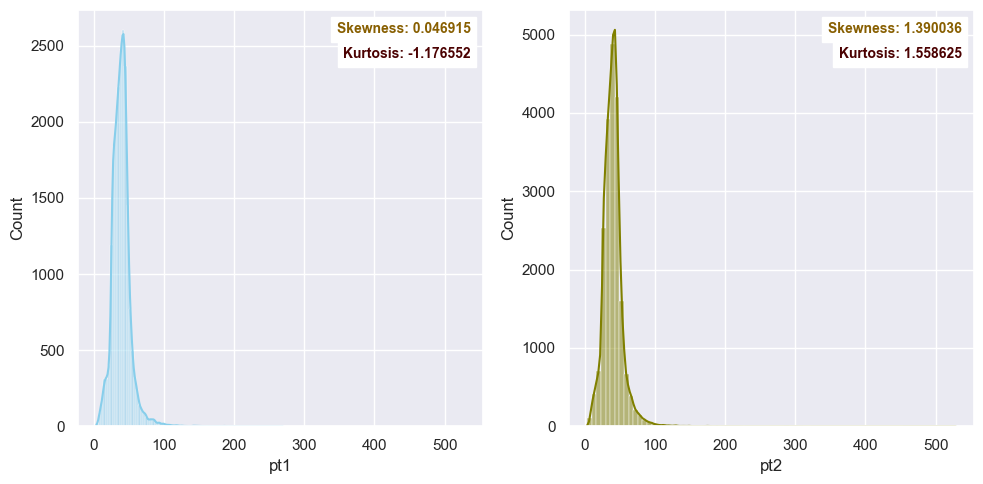

In [9]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.histplot(df.iloc[:,2], color="skyblue", kde=True, ax=axes[0], bins=80)
sns.histplot(df.iloc[:,6], color="olive", kde=True, ax=axes[1], bins=80) 
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % df.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % df.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

# Correlation heatmap

**With `Seaborn's heatmap()` function, I can determine which pairs of variables are most closely related (linearly, it is the pearson correlation).**

<Axes: >

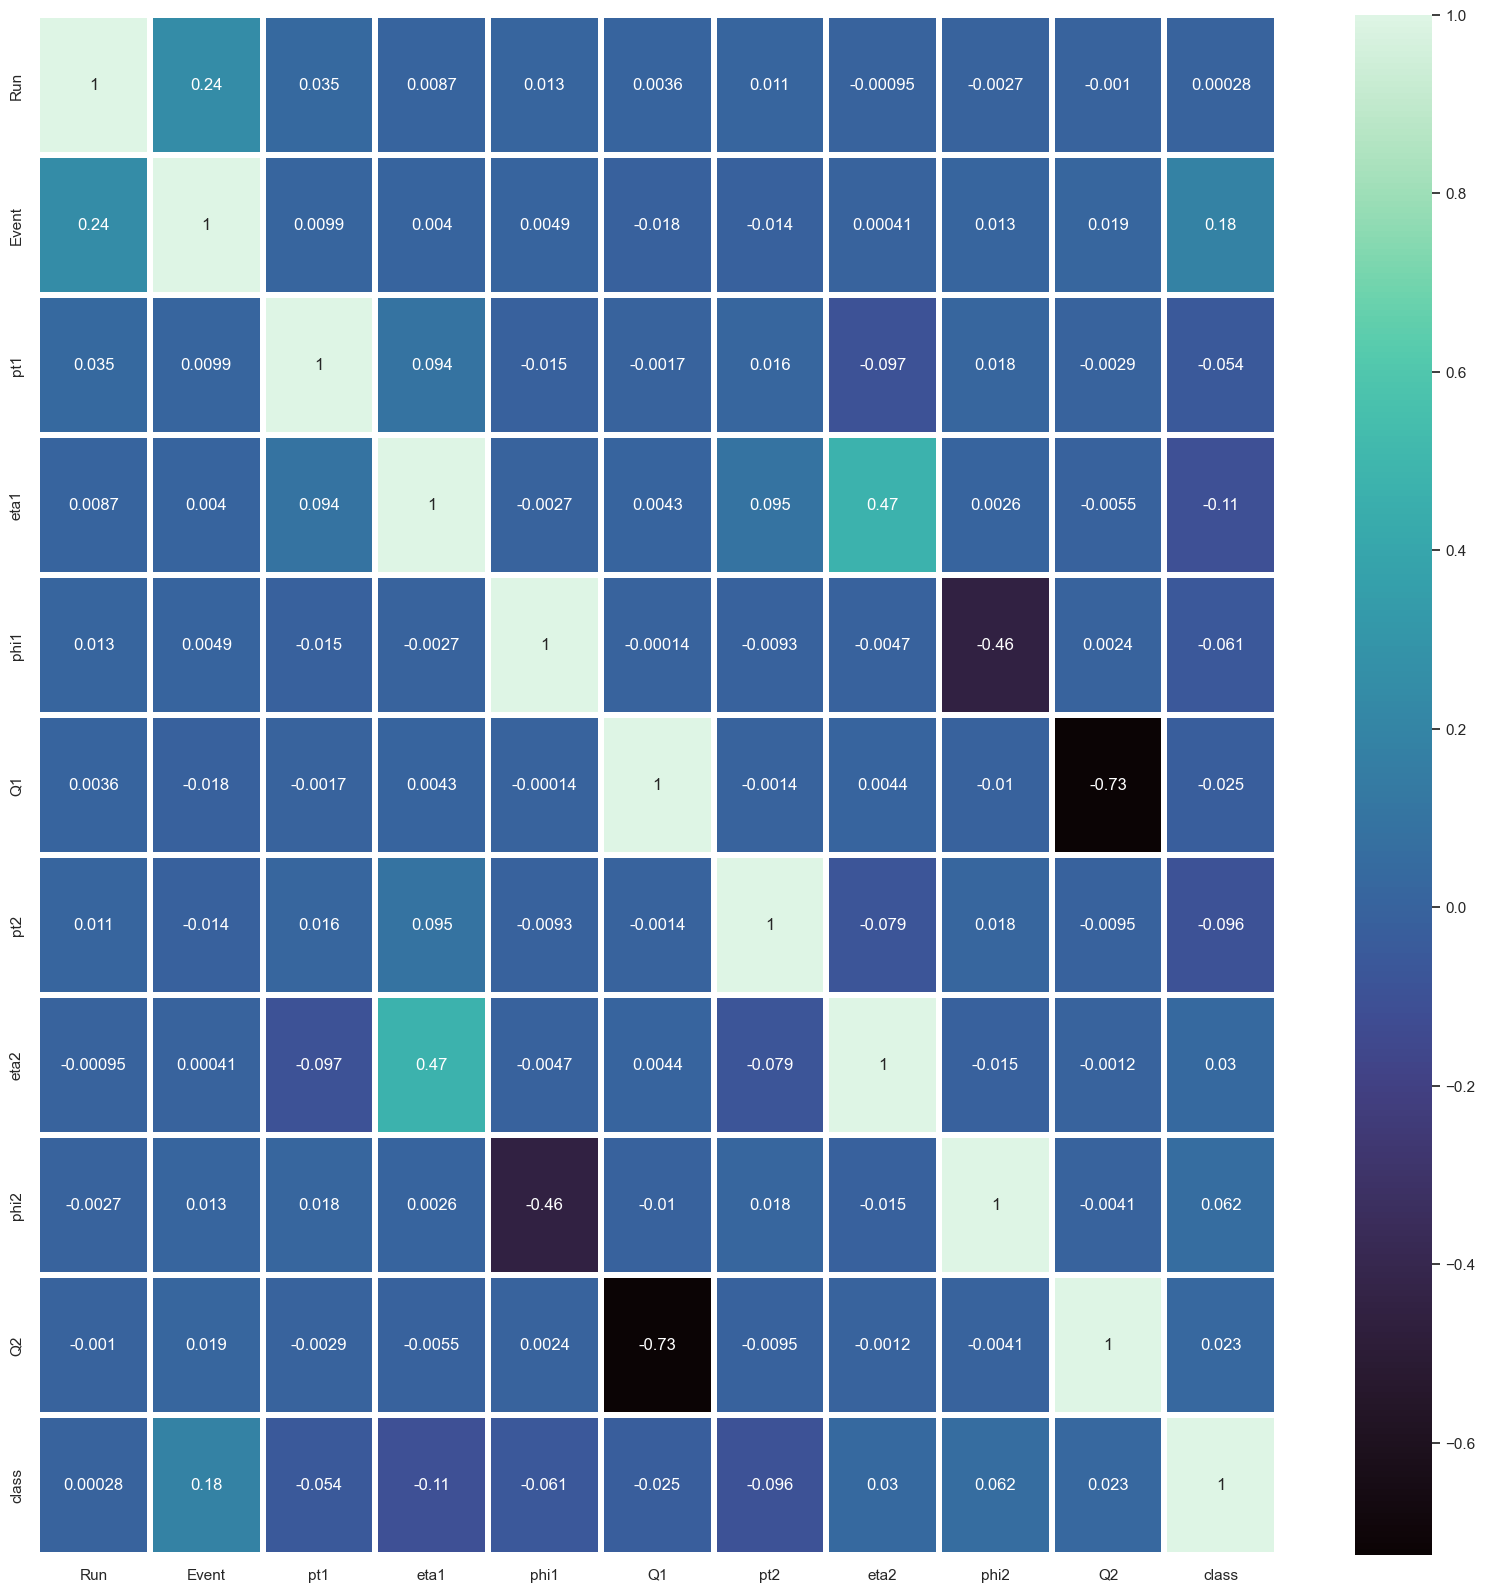

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1.0)
sns.heatmap(df.corr() , annot= True, linewidths=3, ax=ax, cmap='mako')

# Data Visualization:

<Figure size 2000x1000 with 0 Axes>

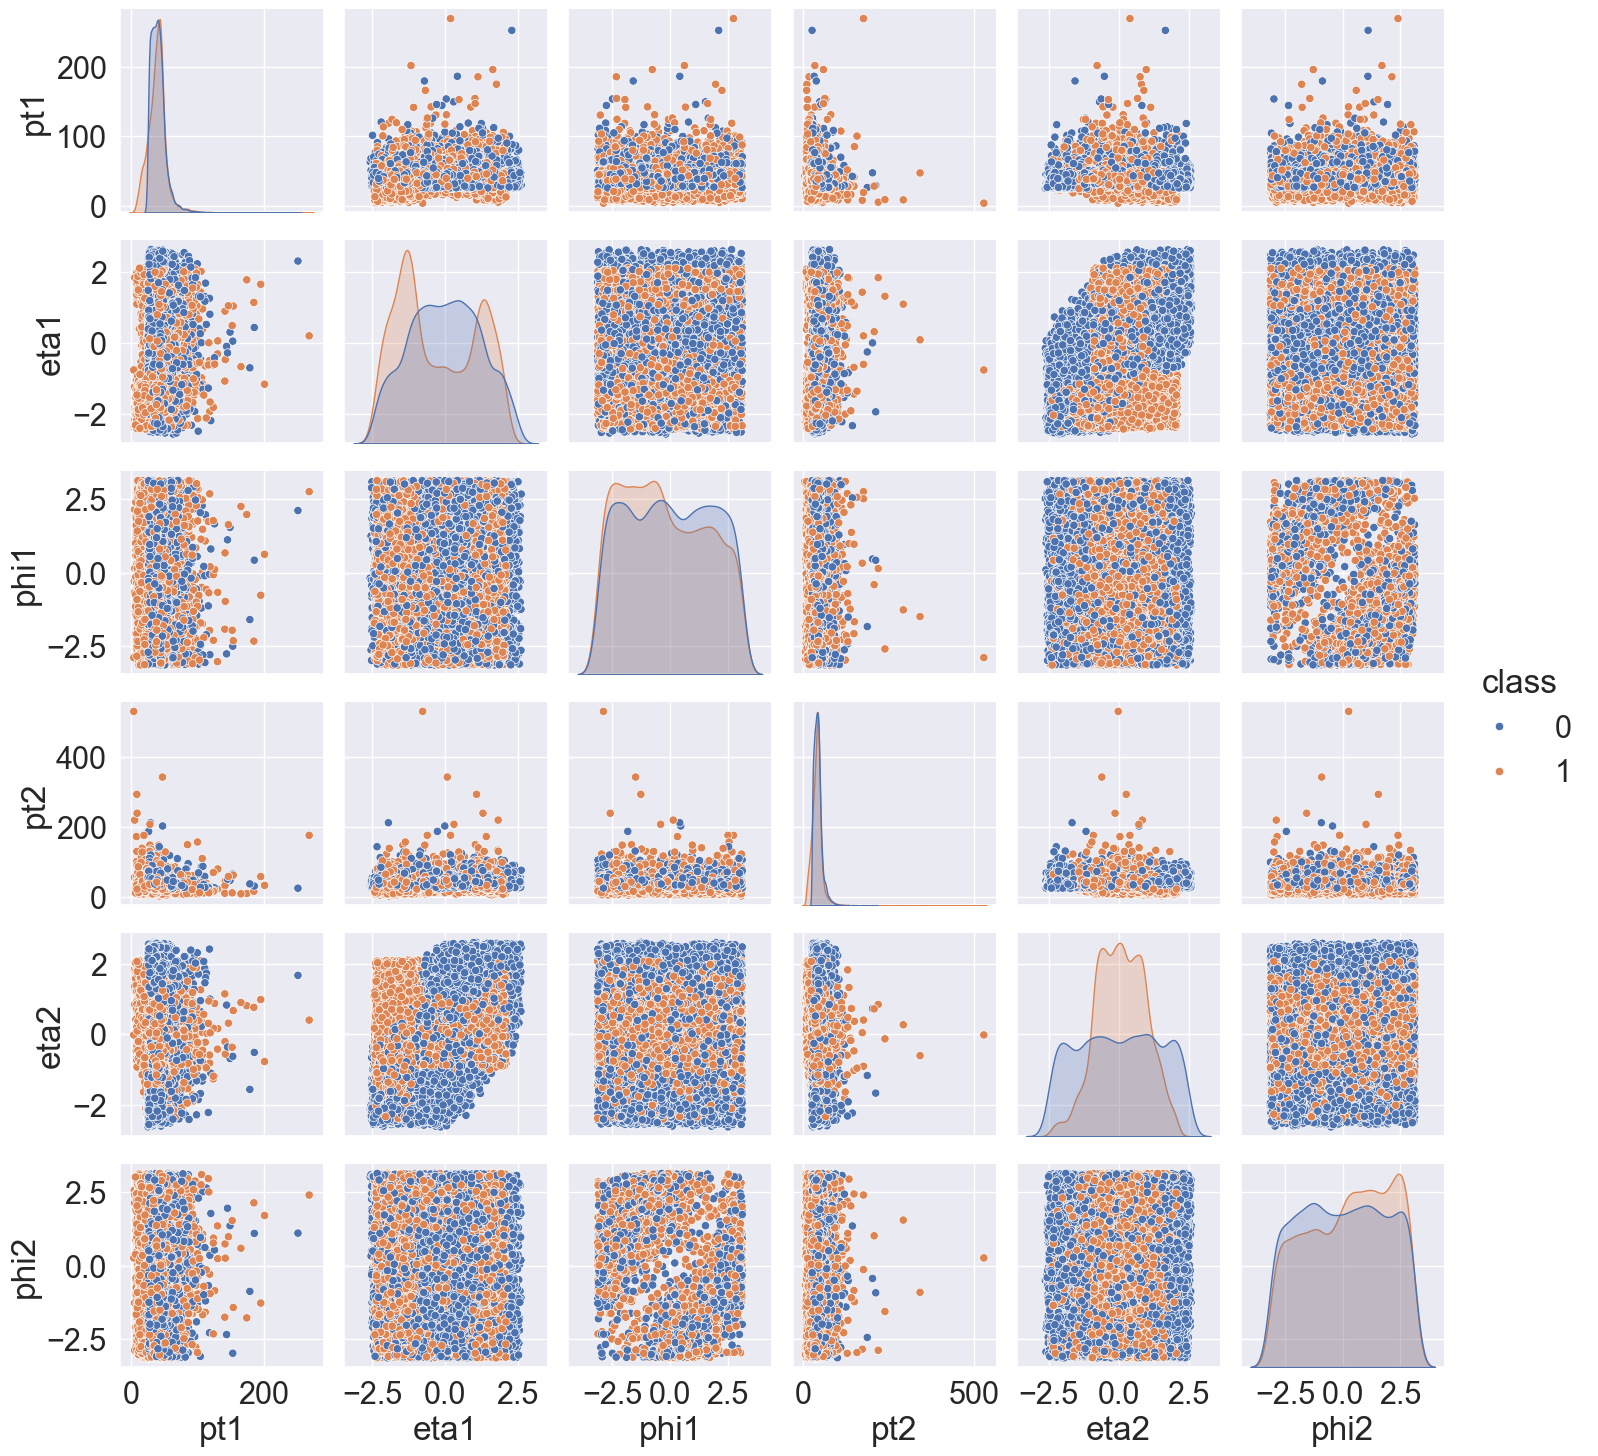

In [8]:
df1 = df[['pt1', 'eta1', 'phi1', 'pt2', 'eta2', 'phi2', 'class']]
plt.figure(figsize=(20, 10))
sns.set(font_scale=2.0)
sns.pairplot(df1, hue="class", palette="deep")

By default, this function will create a grid of Axes such that each numeric variable in df1 will by shared across the y-axes across a single row and the x-axes across a single column. The diagonal plots are treated differently: a univariate distribution plot (ie 1 distrib di 1 sola variabile, a cui puntano riga e col) is drawn (per ciascuna dle 2 eventi ie Zmumu e Zee) to show the marginal distribution (ie le curve blu sono le distrib marginali dl'evento Zee, o Zmumu porta pazienza) of the data in each column. source : [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

# Feature engineering

In [3]:
# pké prenderne i log? è d'aiuto alla regressione?
df["log(pt1)"] = df.pt1.apply(np.log1p) # qsto è un altro modo per accedere alle colonne, nota come in apply() venga passata 1 funzione
df["log(pt2)"] = df.pt2.apply(np.log1p) 
df = df.drop(['pt1', 'pt2'], axis=1)  

I will then use TensorFlow and classical machine learning algorithms to build a model that allows me to distinguish between two modes (Zee and Zmumu).

**First of all, I split the DataFrame into X (data) and Y (label), where:**

In [4]:
X = df.drop(['class'], axis=1) 
y = df['class']  

**Using a train-test split, I split X and Y into train and test data.**



*   Train Dataset: Used to fit model.
*   Test Dataset: Used to evaluate the fit model.



In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # this outputs pandas

# TensorFlow

Here I train a Neural Network using TensorFlow, and then plot accuracy and loss graphs on the training and validation datasets to find a balance between the model that is underfitting and one that is overfitting, resulting in a model with a good fit. I first need to convert the train and test data into a TensorFlow tensor.

**Normalize X_train, X_test**

In [7]:
X_train_scaled = tf.keras.layers.Normalization(axis=-1) # here we're defining a generical normalization layer
X_train_scaled.adapt(tf.convert_to_tensor(X_train)) # here we're informing the layer about mean and variances of each feature

In [8]:
X_test_scaled = tf.keras.layers.Normalization(axis=-1)
X_test_scaled.adapt(tf.convert_to_tensor(X_test))

**Building a simple neural network model**

The compile function takes three arguments: optimizer, loss, and metrics.



*   **Optimizer**: These are certain algorithms that are used to change the attributes of the neural network to decrease the loss rate.
*   **Loss**: This is used to compute the quantity that a model should seek to minimize during training.


*   **Metrics**: This is used to judge the performance of the model.

**Model: There are two hidden layers, each with `64 neurons` and an activation function of `sigmoid`, `epochs = 600`, and `batch_size = 100`.**





In [9]:
def get_basic_model():
  model = tf.keras.Sequential([
    X_train_scaled,
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax) 
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model
model = get_basic_model()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (16000, 10)            │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (88.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21 (88.00 B)

None


In [10]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=100)

Epoch 1/400
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5432 - loss: 0.6854 - val_accuracy: 0.5840 - val_loss: 0.6588
Epoch 2/400
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.5831 - loss: 0.6604 - val_accuracy: 0.5875 - val_loss: 0.6556
Epoch 3/400
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.5924 - loss: 0.6560 - val_accuracy: 0.5725 - val_loss: 0.6582
Epoch 4/400
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.5925 - loss: 0.6512 - val_accuracy: 0.5957 - val_loss: 0.6533
Epoch 5/400
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.5951 - loss: 0.6503 - val_accuracy: 0.5972 - val_loss: 0.6525
Epoch 6/400
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.5935 - loss: 0.6517 - val_accuracy: 0.6033 - val_loss: 0.6515
Epoch 7/400
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.5942 - loss: 0.6500 - val_accuracy: 0.5913 - val_loss: 0.6521
Epoch 8/400
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.5943 - loss: 0.6

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (100, 10)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (100, 64)              │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (100, 64)              │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (100, 2)               │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,005 (58.62 KB)

 Trainable params: 4,994 (19.51 KB)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 9,990 (39.03 KB)

**Evaluating the model**

I create plots from the collected history data.



*   A plot of accuracy on the training and validation datasets over training epochs.
*   A plot of loss on the training and validation datasets over training epochs.



125/125 - 0s - 410us/step - accuracy: 0.8942 - loss: 0.2383


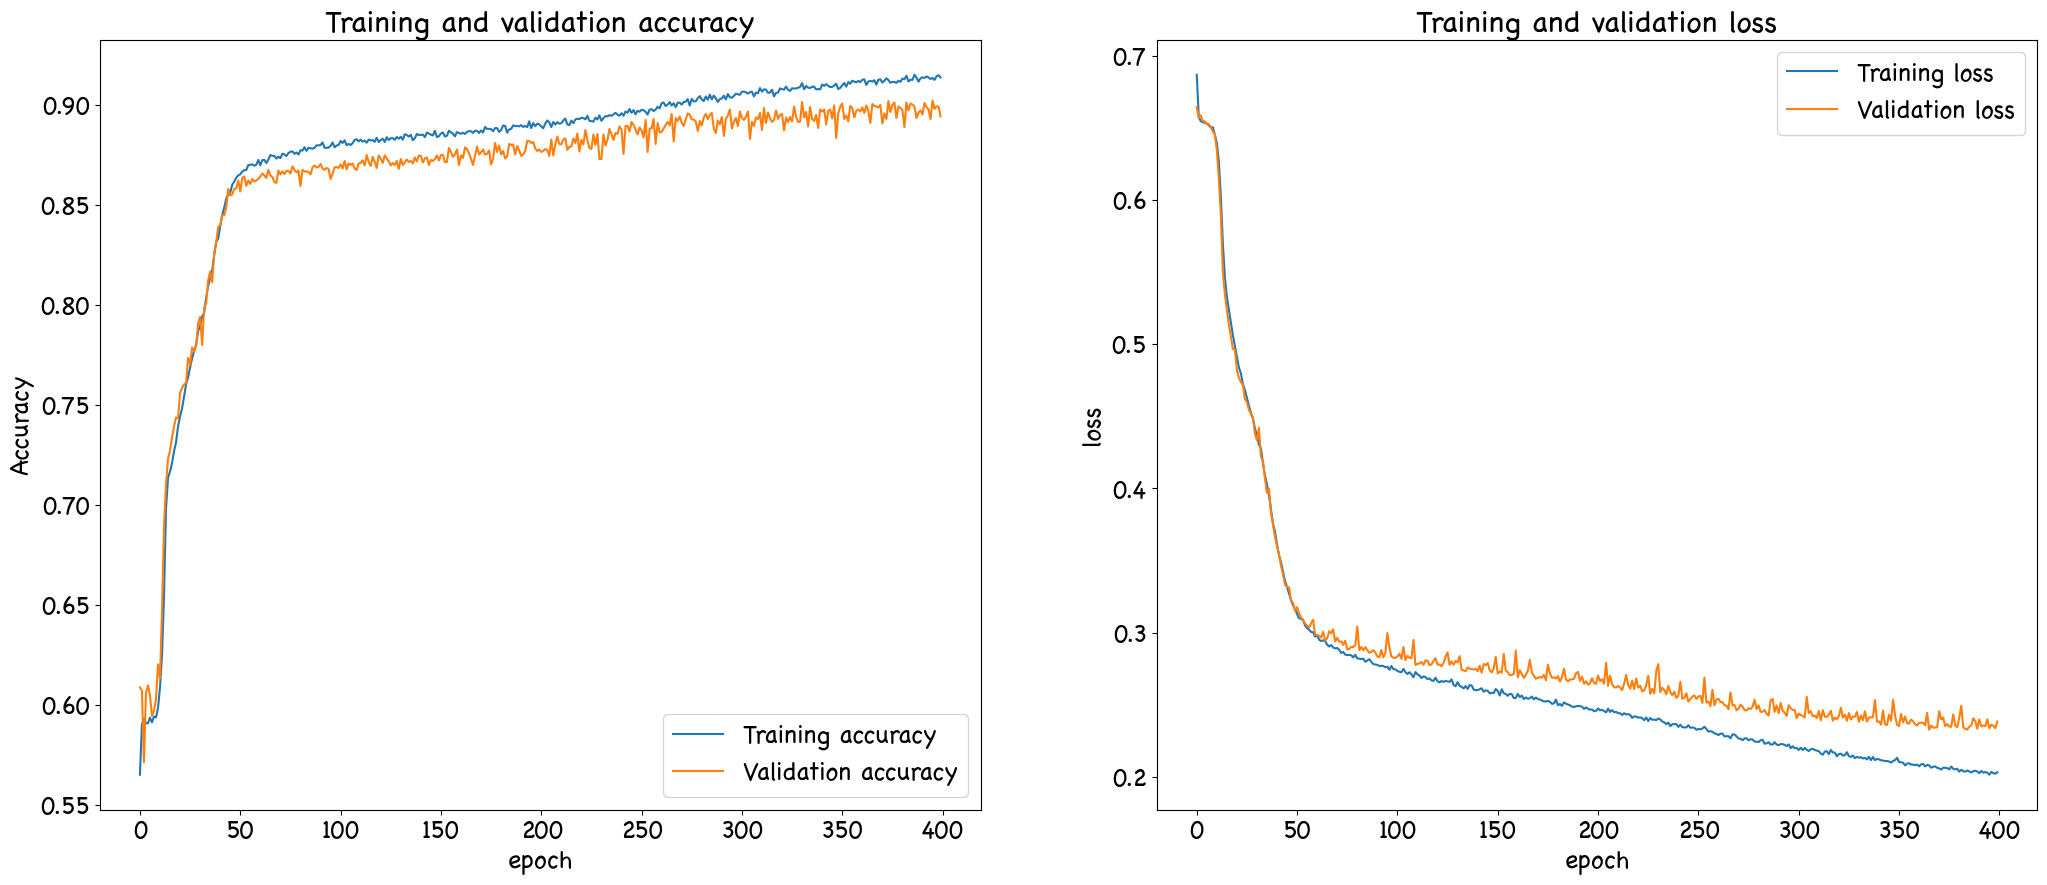

In [17]:
font = {'family' : 'chalkboard',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(25,10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy') 
ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='epoch', ylabel='Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title("Training and validation loss")
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(loc='upper right')
#To check the network accuracy on test data
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

According to the plot of loss, validation loss is decreasing before the 600th epoch, so the model is underfitting. However, after the 600th epoch, validation loss is increasing, which indicates the model is overfitting. At the 600th epoch, when the model is either perfectly fitted or in a local minimum, the neural network model achieved an accuracy of 90%. The goal of Deep Learning is to find a balance between a model that is underfitting and one that is overfitting(converging), resulting in a model with a good fit. I found an optimum where the change in the slope of loss is around the 600th epoch, as shown above. At that point, the training process can be stopped.

# Prediction

In [12]:
classifications_ = model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


array([[9.9997860e-01, 2.1498046e-05],
       [9.9240147e-02, 9.0075988e-01],
       [9.9846447e-01, 1.5355730e-03],
       ...,
       [9.0124585e-02, 9.0987539e-01],
       [8.4453779e-01, 1.5546225e-01],
       [2.7265778e-01, 7.2734225e-01]], dtype=float32)

In [15]:
# Generate arg maxes for predictions
classes = np.argmax(classifications_, axis = 1) # Returns the indices of the maximum values along an axis. 
# Che furbacchione! axis=1 sono le righe, 
# l'indice del massimo (0,1) corrisponde esattamente alla predizione! ie farsi dire dov'è il max = farsi dire la prediz 
# (è come prendere 1 hard max)

In [16]:
X_test1 = X_test.copy()
X_test1['Prediction of class'] = classes.tolist() 
X_test1['real class'] = y_test.tolist() 
df_pred = X_test1[['real class', 'Prediction of class']]
del X_test1
df_pred = df_pred.replace({0: 'Zee', 1: 'Zmumu'}) 
df_pred.head(20) 

,real class,Prediction of class
19134,Zee,Zee
4981,Zee,Zmumu
16643,Zee,Zee
19117,Zee,Zee
5306,Zee,Zee
230,Zmumu,Zmumu
3148,Zmumu,Zmumu
11525,Zee,Zee
13672,Zee,Zee
1624,Zee,Zee
